In [17]:
import numpy as np
import matplotlib.pyplot as plt

class Markov:
    def __init__(self):
        self.iNrStates = None
        self.iMaxTime  = None    
        self.dPij = []
        self.dPijEff = None
        self.dPre = []
        self.dPost= []
        self.dv   = []
        self.dDK  = []
        self.dDKDistr  = []
        self.dCF  = []
        self.dRP  = []
        self.dRPEff  = []
        self.bCalculated = False
        self.bCFCalculated = False
        self.bCalculatedDistr = False
        self.iStart = None
        self.iStop  = None
        self.fDistrLow = -1000
        self.fDistrHigh = 150000
        self.iNrBuckets = 10000
        self.fBucketWidth = (self.fDistrHigh-self.fDistrLow)/self.iNrBuckets
        self.fBucketWidthRound = self.fBucketWidth / 2.
                
    def vDefineModel(self,iNrStates,iMaxTime=1200):
        self.iNrStates = iNrStates
        self.iMaxTime = iMaxTime
        for i in range(iMaxTime):
            tempPij = np.zeros([iNrStates,iNrStates])
            tempPost = np.zeros([iNrStates,iNrStates])
            tempPre = np.zeros([iNrStates])
            tempDK = np.zeros([iNrStates])
            tempCF = np.zeros([iNrStates])
            tempRP = np.zeros([iNrStates])
            tempRPEff = np.zeros([iNrStates])
            self.dPij.append(tempPij)
            self.dPost.append(tempPost)
            self.dPre.append(tempPre)
            self.dDK.append(tempDK)
            self.dCF.append(tempCF)  
            self.dRP.append(tempRP)
            self.dRPEff.append(tempRPEff)
        tempv = np.zeros([iMaxTime])
        self.dv=tempv
        
    def iBucketNr(self, fValue):
        if fValue < self.fDistrLow:
            return(0)
        iBNR = (int(min(self.iNrBuckets-1,(fValue-self.fDistrLow)/self.fBucketWidth+self.fBucketWidthRound)))
        return(iBNR)
    
    def fValueOfBucket(self, iBucket):
        return(self.fBucketWidth*min(self.iNrBuckets-1,iBucket)+self.fDistrLow)
    
    def vCreateDistModel(self):
        print("You Know that you can call me only once everything is done")
        for i in range(self.iMaxTime):
            tempDK = np.zeros([self.iNrStates,self.iNrBuckets])
            self.dDKDistr.append(tempDK)
    
    def vSetDiscounT(self,fIRate):
        vTemp = 1./(1.+fIRate)
        print("Discount %.4f"%(vTemp))
        for i in range(self.iMaxTime):
            self.dv[i] = vTemp
        self.bCalculated = False
        self.bCFCalculated = False
    
    def vSetPij(self,t,i,j,fValue):
        self.dPij[t][i,j] = fValue
        self.bCalculated = False
        self.bCFCalculated = False
    
    def vSetPre(self,t,i,j,fValue):
        self.dPre[t][i] = fValue
        self.bCalculated = False
        self.bCFCalculated = False
    
    def vSetPost(self,t,i,j,fValue):
        self.dPost[t][i,j] = fValue
        self.bCalculated = False
        self.bCFCalculated = False

    def doComplementStates(self,default=None, eps = 0.0001):
        iState = self.iNrStates -1
        if default != None:
            iState = default
        for i in range(self.iNrStates):
            bFound = False
            for t in range(self.iStop,self.iStart):
                fTot = sum(self.dPij[t][i,:])
                #print(i,t,"-->",fTot)
                if abs(fTot-1.) >= eps:
                    bFound=True
                    self.dPij[t][i,default] += 1. - fTot
            if bFound:
                print("Check P(Omega) = 1 failed for iState=",i,"Target State",iState)

    
    def doCalculateDK(self,iStart,iStop,iAge,iState):
        self.iStop = iStop
        self.iStart = iStart
        self.bCalculated = True
        for i in range(self.iMaxTime):
            self.dDK[i] *= 0.
        
        for i in range(self.iStart-1, self.iStop-1,-1):
            #print("Calc Time", i)
            for j in range(self.iNrStates):
                self.dDK[i][j] = self.dPre[i][j]
                for k in range(self.iNrStates):
                    self.dDK[i][j] += self.dv[i]*self.dPij[i][j,k]*(self.dPost[i][j,k]+self.dDK[i+1][k])

    def doCalculateRP(self,iStart,iStop):
        self.doCalculateDK(iStart,iStop,0,0)
        for i in range(self.iStop,self.iStart-1):
            self.dRP[i] *= 0
            self.dRPEff[i] *= 0
            for j in range(self.iNrStates):
                for k in range(self.iNrStates):
                    self.dRP[i][j] += (self.dDK[i+1][k] + self.dPost[i][j,k] - self.dDK[i+1][j])* self.dPij[i][j,k]
                    self.dRPEff[i][j] += (self.dDK[i+1][k] + self.dPost[i][j,k] - self.dDK[i+1][j])* self.dPijEff[i][j,k]
            self.dRP[i] *= self.dv[i]
            self.dRPEff[i] *= self.dv[i]
            
            
    def doCalculateCF(self,iStart,iStop,iAge,iState,bTrace=False):
        self.iStop = iStop
        self.iStart = iStart
        self.bCFCalculated = True
        for i in range(self.iMaxTime):
            self.dCF[i] *= 0.
        
        CurrentP = np.mat(np.identity(self.iNrStates))
        if bTrace:
            print("----- ----- ----- ----- ")
        for i in range(self.iStop, self.iStart):
            if bTrace:
                print("----- ----- ----- ----- ")
                print(" Time ", i)
                print("CF BoP", self.dCF[i])
            for k in range(self.iNrStates):
                for l in range(self.iNrStates):
                    self.dCF[i][k] += CurrentP[k,l] * self.dPre[i][l]
            if bTrace:
                print("CF BoP after Pre", self.dCF[i])
            NextP = np.mat(self.dPij[i])
            if bTrace:
                print("+++++ +++++ +++++ ")
                print("CurrentP\n", CurrentP) 
                print("+++++ +++++ +++++ ")
                print("Next P\n", NextP) 
                print("+++++ +++++ +++++ ")
                
            for k in range(self.iNrStates):
                for l in range(self.iNrStates):
                    for m in range(self.iNrStates):
                        self.dCF[i+1][k] += CurrentP[k,l] * NextP[l,m] * self.dPost[i][l,m]
            if bTrace:
                print("CF EoP t", self.dCF[i])
                print("CF EoP t+1", self.dCF[i+1])
            
            CurrentP = CurrentP * NextP
            if bTrace:
                print("+++++ +++++ +++++ ")
                print("CurrentP EoP\n", CurrentP) 
                print("+++++ +++++ +++++ ")

    def doCalculateDKDistr(self,iStart,iStop,iAge,iState,default=None):
        self.iStop = iStop
        self.iStart = iStart
        self.bCalculatedDistr = True
        self.vCreateDistModel()
        print("default is",str(default))
        self.doComplementStates(default=default)
        for i in range(self.iMaxTime):
            self.dDKDistr[i] *= 0.
        # Set Boundary Conditions
        iIndexSwitch = self.iBucketNr(0)
        for j in range(self.iNrStates):
            value = 0.
            for l in range(self.iNrBuckets):
                if l > iIndexSwitch:
                           value = 1.
                self.dDKDistr[self.iStart][j,l] = value
        # Calculation                   
        for i in range(self.iStart-1, self.iStop-1,-1):
            print("Dirst DK Calc Time", i)
            for j in range(self.iNrStates):
                for k in range(self.iNrStates):
                    for l in range(self.iNrBuckets):
                        dNewXTPlusOne = (self.fValueOfBucket(l) - self.dPre[i][j])/self.dv[i] - self.dPost[i][j,k]
                        self.dDKDistr[i][j,l] += self.dPij[i][j,k]*(self.dDKDistr[i+1][k,self.iBucketNr(dNewXTPlusOne)])
                                      
    
    def dGetDK(self,iStart,iStop,iAge,iState):
        if (iStart != self.iStart or iStop != self.iStop or not(self.bCalculated)):
            self.doCalculateDK(iStart,iStop,iAge,iState)
        return(self.dDK[iAge][iState])

    def dGetCF(self,iStart,iStop,iAge,iState):
        if (not(self.bCFCalculated) or self.iStart != iStart or self.iStop != iStop ):
            self.doCalculateCF(iStart,iStop,iAge,iState)
        return(self.dCF[iAge][iState])
    
    def dGetDKDistr(self,iStart,iStop,iAge,iState,fValue,default=None):
        if (iStart != self.iStart or iStop != self.iStop or not(self.bCalculatedDistr)):
            temp = self.dGetDK(iStart,iStop,iAge,iState) # To be on the safe side
            self.doCalculateDKDistr(iStart,iStop,iAge,iState,default=default)
        return(self.dDKDistr[iAge][iState,self.iBucketNr(fValue)])
    
    def PrintDKs(self,iStart,iStop):
        for i in range(iStop,iStart+1):
            strTemp = " %3d :"%(i)
            for j in range(self.iNrStates):
                 strTemp += "  %7.0f "%(self.dGetDK(iStart,iStop,i,j))
            print(strTemp)
        
    def PrintDKPLUS(self,iStart,iStop):
        self.doCalculateRP(iStart,iStop)
        for i in range(iStop,iStart+1):
            strTemp = " %3d :"%(i)
            for j in range(self.iNrStates):
                 strTemp += "  %7.0f "%(self.dGetDK(iStart,iStop,i,j))
            print(strTemp)
            strTemp = " %3s :"%("RP ")
            for j in range(self.iNrStates):
                 strTemp += "  %7.0f "%(self.dRP[i][j])
            print(strTemp)
            strTemp = " %3s :"%("PnL")
            for j in range(self.iNrStates):
                 strTemp += "  %7.1f "%(self.dRP[i][j]-self.dRPEff[i][j])
            print(strTemp+"\n ----  ==========================================================================================")
            
    
    def PlotDKs(self,iStart,iStop,figNr=1):
        x = []
        y = []
        for i in range(iStop,iStart+1):
            x.append(i)
            ytemp = np.zeros(self.iNrStates)
            for j in range(self.iNrStates):
                ytemp[j] = self.dGetDK(iStart,iStop,i,j)
            y.append(ytemp)
        plt.figure(figNr)
        plt.plot(x,y)
        plt.grid(True)

    def PlotCFs(self,iStart,iStop,figNr=2,bLines=True,iMaxState=500):
        import matplotlib.colors as mcolors
        if bLines:
            x=[]
            y=[]
            plt.figure(figNr)
                
            for j in range(min(iMaxState,self.iNrStates)):
                x=[]
                y=[]
                for i in range(iStop,iStart+1):
                    x.append(i)
                    y.append(self.dGetCF(iStart,iStop,i,j))
                plt.plot(x,y)
            plt.grid(True)
        else:
            A= []
            for i in mcolors.TABLEAU_COLORS.keys():
                A.append(i)
            for i in mcolors.BASE_COLORS.keys():
                A.append(i)
        
            xBar =[]
            hBar =[]
            bBar =[]
            cBar =[]
            y = []
            for i in range(iStop,iStart+1):
              for j in range(self.iNrStates):
                xBar.append(i+(j)*1./self.iNrStates)
                hBar.append(self.dGetCF(iStart,iStop,i,j))
                bBar.append(0)
                cBar.append(A[j])
            
            plt.figure(figNr)
            plt.bar(xBar,hBar,bottom=bBar, width = 1./min(iMaxState,self.iNrStates),color=cBar)
            plt.grid(True)
    
    def PlotDKDistr(self,iStart,iStop, iSteps = None, iStates = [0], iDeltaT = 5, figNr=10, eps = 0.01,legTitle="",default=None):
        if iSteps == None:
            iSteps = []
            for i in range(iStop,iStart,iDeltaT):
                iSteps.append(i)
            iSteps.append(iStart)
        for i in iSteps:
            for j in iStates:
                x = []
                y = []
                for k in range(self.iNrBuckets):
                    xLoc = eps + self.fValueOfBucket(k)
                    yLoc = self.dGetDKDistr(iStart,iStop,i,j,xLoc,default=default)
                    x.append(xLoc)
                    y.append(yLoc)
    
                plt.figure(figNr)
                plt.plot(x,y)
                plt.grid(True)
                mylegend = legTitle + "Age %d - State %d"%(i,j)
                plt.title(mylegend)
                figNr+=1


def read_array(filename, mylen):
    """ Read a file with an arbitrary number of columns.
        The type of data in each column is arbitrary
        It will be cast to the given dtype at runtime
    """
    return (np.loadtxt(filename))

print('Calculating LTC')
# ============================================================
iVon  = 65 #  int(input("Start Alter (40) ")) 
iNach = 100 # int(input("End Alter (100) "))
iProduceAudit = 0
#symTex = open("test.tex","w")
# ============================================================
pij = read_array('pij.dat', 4)
post = read_array('post.dat', 4)
pre = read_array('pre.dat', 4)
PrePrem1 = read_array('PrePrem1.dat',4)
zins = read_array("zins.dat", 2)
# ============================================================
fid = open('MResult.dat','w');
pHandlePrem  = Markov()
pHandleBenefits  = Markov()
pHandleDK = Markov()
pHandlePrem.vDefineModel(9)
pHandleBenefits.vDefineModel(9)
pHandleDK.vDefineModel(9)

# ============================================================
iStart = iNach
iStop = iVon
fInterstRate = 0.04
# ============================================================

print('Init pij')
for i in  range(pij.shape[0]):
    pHandlePrem.vSetPij(int(pij[i,0]), int(pij[i,1]),int(pij[i,2]), pij[i,3])
#    print "Pij  %d %d %d %10.4f" %(int(0.005+pij[i,0]), int(0.005+pij[i,1]-1),int(0.005+pij[i,2]-1), dTemp)
    pHandleBenefits.vSetPij(int(pij[i,0]), int(pij[i,1]),int(pij[i,2]), pij[i,3])
#    print "Pij2 %d %d %d %10.4f" % (int(0.005+pij[i,0]), int(0.005+pij[i,1]),int(0.005+pij[i,3]), pij[i,3])
    pHandleDK.vSetPij(int(pij[i,0]), int(pij[i,1]),int(pij[i,2]), pij[i,3])

print('Init post')

#for i in  range(post.shape[0]):
pHandlePrem.vSetPost(0,0,0,0)
pHandleBenefits.vSetPost(0,0,0,0)

print('Init pre')
for i in range(0,120):
    j= 3
    pHandleBenefits.vSetPre(i, j, j, 6000.)
    pHandleDK.vSetPre(i, j, j, 6000.)
    for j in range(4,8):
        pHandleBenefits.vSetPre(i, j, j, 12000.)
        pHandleDK.vSetPre(i, j, j, 12000.)

for i in  range(PrePrem1.shape[0]):
    pHandlePrem.vSetPre(int(PrePrem1[i,0]), int(PrePrem1[i,1]),int(PrePrem1[i,2]), PrePrem1[i,3])
#    print "PRE2 %d %10.4f" %(int(0.005+pre[i,0]), dTemp)

pHandlePrem.vSetDiscounT(fInterstRate)
pHandleBenefits.vSetDiscounT(fInterstRate)  
pHandleDK.vSetDiscounT(fInterstRate)    
                        
Prem = pHandleBenefits.dGetDK(iStart,iStop,iStop,1) /  pHandlePrem.dGetDK(iStart,iStop,iStop,1)
                        
print("Premium %.2f"%(Prem))
                        
for i in  range(0,120):    
    pHandleDK.vSetPre(i, 1, 1, Prem)
    pHandleDK.vSetPre(i, 2, 2, Prem)
                        

#      print int(0.005+zins[i,0]), j,j, zins[i,1]
# ============================================================
values = np.zeros((100,4), dtype='f')
j= 0
for i in range(65, 75):
    P_1 = pHandleBenefits.dGetDK(iStart,iStop,i,1) /  pHandlePrem.dGetDK(iStart,iStop,i,1) + 0.000001
#    print  i, pHandleBenefits.dGetDK(i,1,1), pHandlePrem.dGetDK(i,1,1), pHandleBenefits.dGetDK(i,4,1)
    P_2 = pHandleBenefits.dGetDK(iStart,iStop,i,2) /  pHandlePrem.dGetDK(iStart,iStop,i,2) + 0.000001
    strTemp = 'x  %5d   P1  %10.5f    P2  %10.5f     Verh %5.2f %%'%(i,P_1, P_2, 100 * P_2 / P_1)
    print(strTemp)
    fid.write(strTemp+"\n")
    values[j,0]=  i
    values[j,1]= P_1
    values[j,2]= P_2
    values[j,3]= P_2/P_1
    j = j + 1
#pHandleBenefits.vPrintTeX(symTex,True,"Test", True)
#symTex.close()


# ============================================================

Calculating LTC
Init pij
Init post
Init pre
Discount 0.9615
Discount 0.9615
Discount 0.9615
Premium -600.27
x     65   P1  -600.27007    P2  -3091.98643     Verh 515.10 %
x     66   P1  -626.50554    P2  -3198.39299     Verh 510.51 %
x     67   P1  -654.00031    P2  -3307.52892     Verh 505.74 %
x     68   P1  -682.88209    P2  -3419.97764     Verh 500.82 %
x     69   P1  -713.26122    P2  -3536.89019     Verh 495.88 %
x     70   P1  -745.60821    P2  -3659.48881     Verh 490.81 %
x     71   P1  -781.18412    P2  -3783.54793     Verh 484.33 %
x     72   P1  -819.91371    P2  -3906.14312     Verh 476.41 %
x     73   P1  -860.93544    P2  -4028.50216     Verh 467.92 %
x     74   P1  -904.47833    P2  -4154.06333     Verh 459.28 %


**How to implement Waiting Perods?**

In the original model you have states 1,2,3,.. 7 repesenting the amount of DLA which you could do

- 1: you can do everything
- 2: 1 DLA is missing
- 3: 2 DLA are missing
- etc

For a waiting period of 2 years you would choose the following states

- instead of state 3 you would have states 3a, 3b, 3c, where you are in a at the beginning, in b after b after a year and later on in c
- you pay onlz in state 3c
- ditto for the other higher states

Transition prob

- pij (i,j) with i = n(A,B,C) to j = m(A,B,C) as follows

pij (i,j) = pij(n,m)

In [18]:
pHandleDK.PrintDKs(iNach, iVon)

  65 :        0        -0     17583     41451     49364     54495     44028     44783     23047 
  66 :        0       283     17442     40624     48413     52528     43171     44577     22485 
  67 :        0       561     17261     39781     47457     50600     42336     44308     21916 
  68 :        0       835     17044     38927     46499     48715     41524     43979     21343 
  69 :        0      1102     16802     38065     45545     46881     40736     43597     20770 
  70 :        0      1366     16545     37200     44595     45100     39972     43160     20199 
  71 :        0      1635     16262     36332     43654     43378     39234     42656     19633 
  72 :        0      1908     15944     35468     42724     41716     38521     42087     19073 
  73 :        0      2178     15592     34612     41808     40117     37834     41458     18524 
  74 :        0      2446     15208     33767     40906     38582     37172     40772     17986 
  75 :        0      2696     

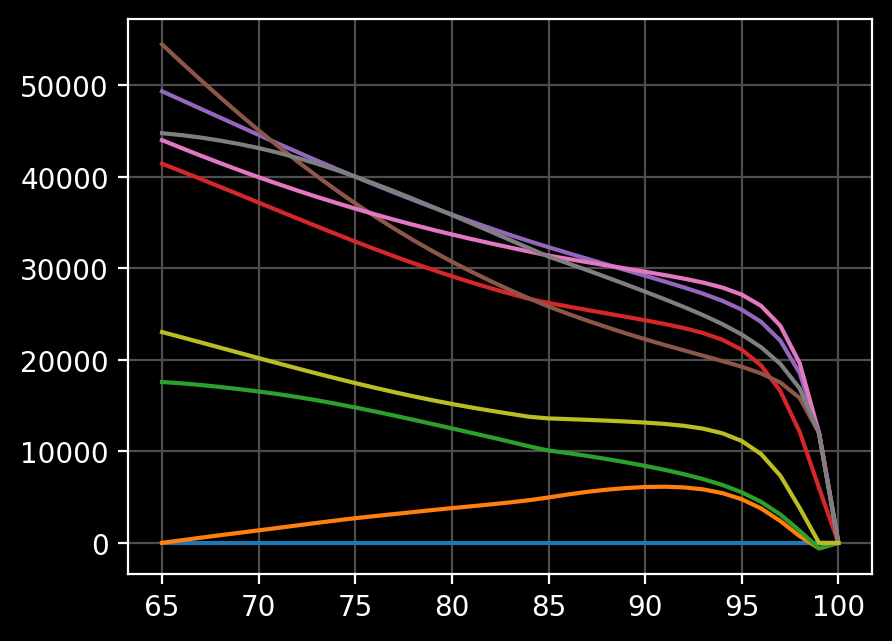

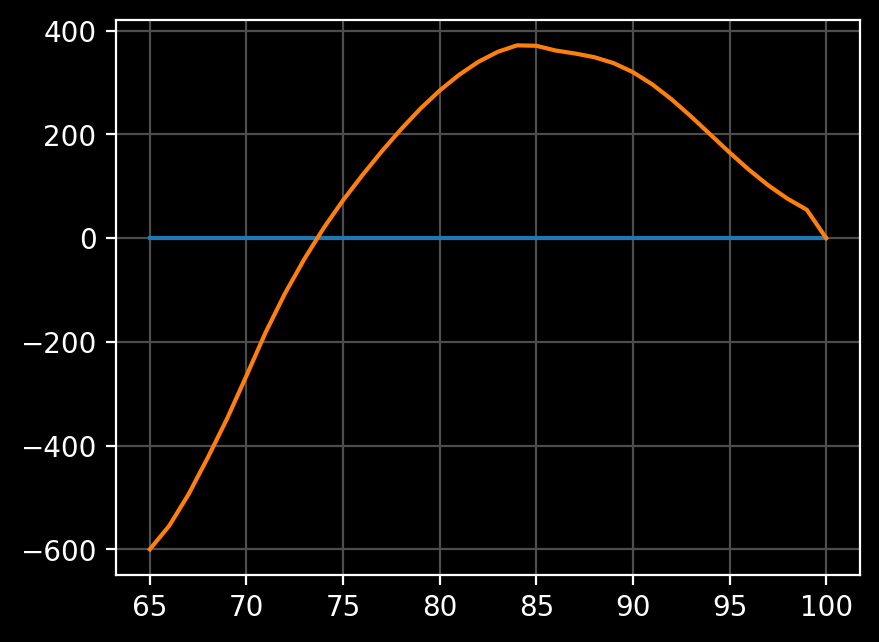

In [19]:
pHandleDK.PlotDKs(iNach, iVon)
pHandleDK.PlotCFs(iNach, iVon,figNr=2,bLines=True,iMaxState=2)

In [20]:
fFactors = np.zeros([125,9])

lam = 0.02

for i in range (66,120):
    fFactors[i,:]=(1-lam)**(i-65)
    
fFactors2 = np.zeros([125,9])

lam = 0.02

for i in range (66,120):
    fFactors2[i,:3]=(1-lam)**(i-65)
    fFactors2[i,3:]=(1-2*lam)**(i-65)

#print(fFactors[65:70,1:3])
    
def vDoTransform(pdVon, pdTo, fFactors):
    for t in range(66,101):
        for j in range(1,9):
            qx = pdVon.dPij[t][j,0]
            qxNeu = qx * fFactors[t,j]
            fact = (1-qxNeu)/(1-qx)
            #print(t,j,fact)
            pdTo.dPij[t][j,0] = qxNeu
            pdTo.dPij[t][j,1:] *= fact
            #print(sum(pdTo.dPij[t][j,:]),sum(pdVon.dPij[t][j,:]))
            
            

  65 :        0      2692     20586     44285     52186     57202     46077     47815     25793 
  66 :        0      3128     20737     43907     51721     55817     45892     47927     25611 
  67 :        0      3564     20856     43520     51253     54463     45714     47990     25425 
  68 :        0      4001     20949     43127     50785     53146     45544     48007     25238 
  69 :        0      4436     21023     42732     50320     51867     45384     47986     25054 
  70 :        0      4872     21092     42335     49859     50631     45234     47926     24873 
  71 :        0      5322     21141     41938     49404     49441     45094     47812     24696 
  72 :        0      5789     21159     41544     48957     48298     44965     47645     24526 
  73 :        0      6264     21147     41158     48519     47205     44847     47429     24365 
  74 :        0      6753     21102     40782     48093     46163     44740     47164     24214 
  75 :        0      7218     

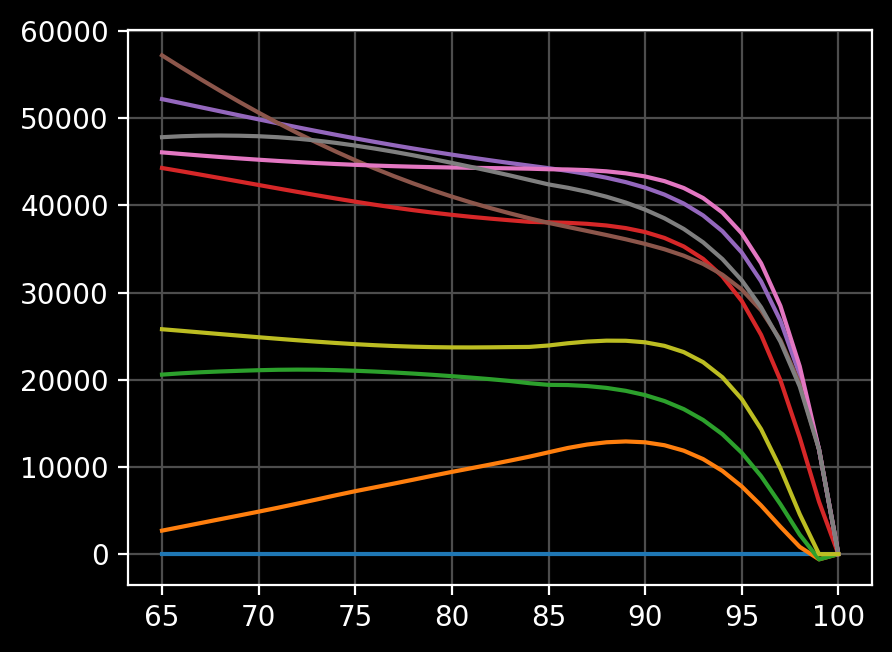

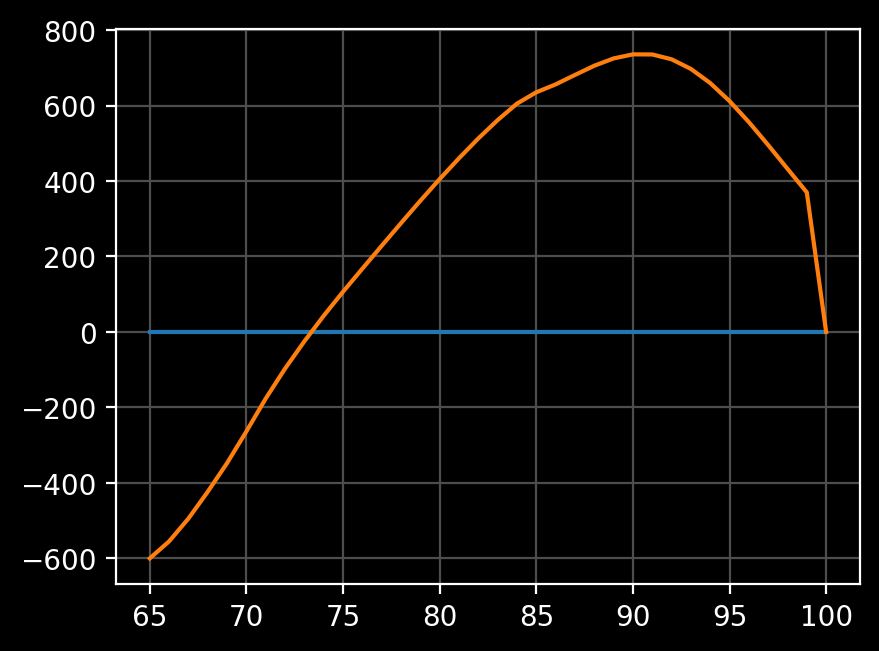

In [21]:
import copy
pdDK = copy.deepcopy(pHandleDK)
vDoTransform(pHandleDK, pdDK, fFactors)
pdDK.bCalculated = False
pdDK.bCFCalculated = False
pdDK.PrintDKs(iNach, iVon)
pdDK.PlotDKs(iNach, iVon)
pdDK.PlotCFs(iNach, iVon,figNr=2,bLines=True,iMaxState=2)

  65 :        0      5260     23850     47604     55569     60517     48581     51159     28988 
  66 :        0      5833     24325     47793     55718     59860     49223     51664     29291 
  67 :        0      6410     24775     47988     55875     59238     49870     52142     29601 
  68 :        0      6990     25204     48192     56043     58654     50523     52597     29923 
  69 :        0      7569     25620     48407     56222     58112     51182     53038     30258 
  70 :        0      8151     26035     48634     56414     57613     51848     53464     30607 
  71 :        0      8753     26433     48871     56617     57160     52520     53858     30969 
  72 :        0      9380     26798     49120     56834     56754     53198     54219     31345 
  73 :        0     10023     27126     49384     57065     56396     53881     54550     31735 
  74 :        0     10688     27410     49662     57307     56086     54567     54846     32142 
  75 :        0     11318     

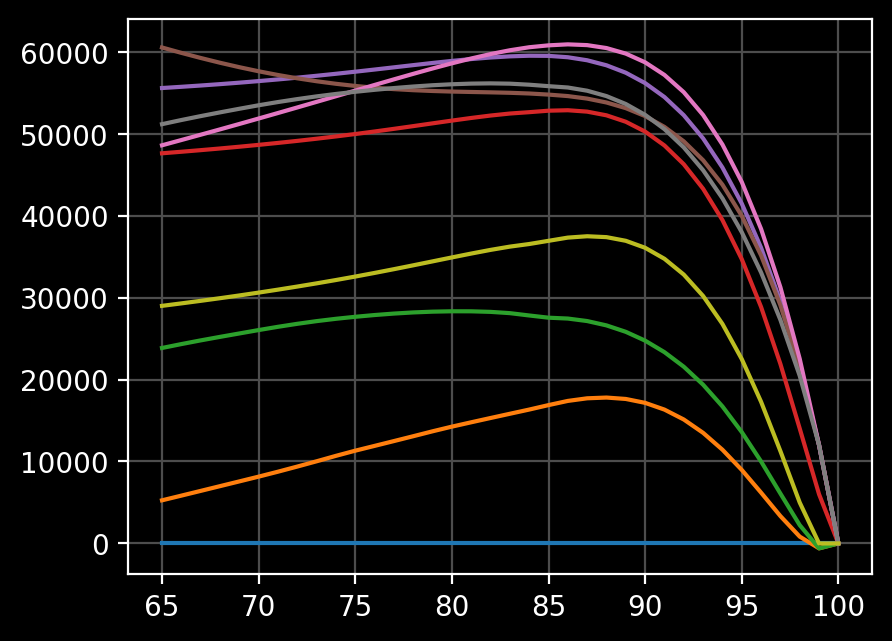

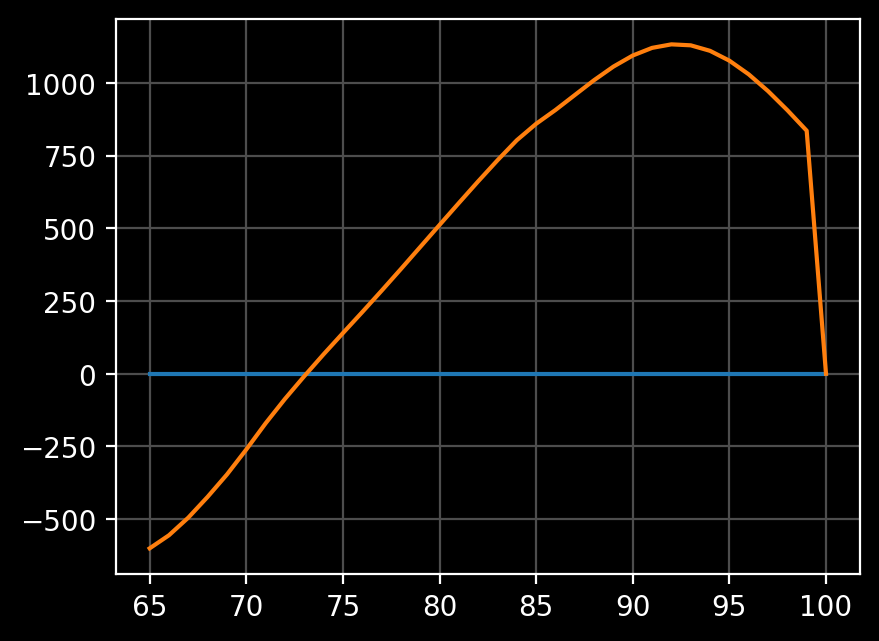

In [22]:
pdDK2 = copy.deepcopy(pHandleDK)
vDoTransform(pHandleDK, pdDK2, fFactors2)
pdDK2.bCalculated = False
pdDK2.bCFCalculated = False
pdDK2.PrintDKs(iNach, iVon)
pdDK2.PlotDKs(iNach, iVon)
pdDK2.PlotCFs(iNach, iVon,figNr=2,bLines=True,iMaxState=2)

In [23]:
pHandleDK.dPijEff = copy.deepcopy(pdDK.dPij)
pHandleDK.PrintDKPLUS(iNach, iVon)

  65 :        0        -0     17583     41451     49364     54495     44028     44783     23047 
 RP  :        0       329      1412     -3611     -9187     -8013     -9482    -10080      1427 
 PnL :      0.0       0.0       0.0       0.0       0.0       0.0       0.0       0.0       0.0 
 ----  ==========================================================================================
  66 :        0       283     17442     40624     48413     52528     43171     44577     22485 
 RP  :        0       343      1445     -3627     -9218     -8125     -9536    -10027      1412 
 PnL :      0.0      -0.3     -10.7     -80.6     -88.5    -136.2    -231.4     -19.3     -52.4 
 ----  ==========================================================================================
  67 :        0       561     17261     39781     47457     50600     42336     44308     21916 
 RP  :        0       359      1472     -3649     -9254     -8242     -9591     -9979      1394 
 PnL :      0.0      -0.9   

In [24]:
pHandleDK.dPijEff = copy.deepcopy(pdDK2.dPij)
pHandleDK.PrintDKPLUS(iNach, iVon)

  65 :        0        -0     17583     41451     49364     54495     44028     44783     23047 
 RP  :        0       329      1412     -3611     -9187     -8013     -9482    -10080      1427 
 PnL :      0.0       0.0       0.0       0.0       0.0       0.0       0.0       0.0       0.0 
 ----  ==========================================================================================
  66 :        0       283     17442     40624     48413     52528     43171     44577     22485 
 RP  :        0       343      1445     -3627     -9218     -8125     -9536    -10027      1412 
 PnL :      0.0      -0.3     -10.7    -161.3    -177.0    -272.5    -462.8     -38.6    -104.7 
 ----  ==========================================================================================
  67 :        0       561     17261     39781     47457     50600     42336     44308     21916 
 RP  :        0       359      1472     -3649     -9254     -8242     -9591     -9979      1394 
 PnL :      0.0      -0.9   

In [25]:
for i in range(80,85):
    j=8
    print(i,"\n ----")
    #print(pHandleDK.dPij[i][j,:])
    #print(pHandleDK.dPijEff[i][j,:])

80 
 ----
81 
 ----
82 
 ----
83 
 ----
84 
 ----
